In [ ]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## S&P 500 Stocks 
#### Authors: študenti IAU 2024

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats  
import matplotlib
from sklearn import preprocessing
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import math
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

# Loading input data

**Data** https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks (97MB)

The Standard and Poor's 500 or S&P 500 is the most famous financial benchmark in the world.
This stock market index tracks the performance of 500 large companies listed on stock exchanges in the United States. 

Download the data and place files into the folder **sp-500-stock/**

In [2]:
companies = pd.read_csv("sp-500-stock/sp500_companies.csv", sep=',')
index =  pd.read_csv("sp-500-stock/sp500_index.csv", sep=',')
stocks =  pd.read_csv("sp-500-stock/sp500_stocks.csv", sep=',')

In [3]:
companies.head(2)

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,239.59,3621594333184,1.346610e+11,0.061,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.064235
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,138.63,3395048964096,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.060216


In [4]:
index.head(2)

,Date,S&P500
0,2014-12-01,2053.44
1,2014-12-02,2066.55


In [5]:
stocks.head(2)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,MMM,NaN,NaN,NaN,NaN,NaN,NaN


# Basic data description

In [6]:
BOLD = "\033[1m"
END = "\033[0m"
print(f"{BOLD}Companies:{END} Počet záznamov: {companies.shape[0]}, Počet atributov: {companies.shape[1]}\n{companies.dtypes}\n")
print(f"{BOLD}Index:{END} Počet záznamov: {index.shape[0]}, Počet atributov: {index.shape[1]}\n{index.dtypes}\n")
print(f"{BOLD}Stocks:{END} Počet záznamov: {stocks.shape[0]}, Počet atributov: {stocks.shape[1]}\n{stocks.dtypes}")

Companies: Počet záznamov: 503, Počet atributov: 16
Exchange                object
Symbol                  object
Shortname               object
Longname                object
Sector                  object
Industry                object
Currentprice           float64
Marketcap                int64
Ebitda                 float64
Revenuegrowth          float64
City                    object
State                   object
Country                 object
Fulltimeemployees      float64
Longbusinesssummary     object
Weight                 float64
dtype: object

Index: Počet záznamov: 2517, Počet atributov: 2
Date       object
S&P500    float64
dtype: object

Stocks: Počet záznamov: 1888262, Počet atributov: 8
Date          object
Symbol        object
Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume       float64
dtype: object


The companies table is not essential for model development, so we will no longer work with it.

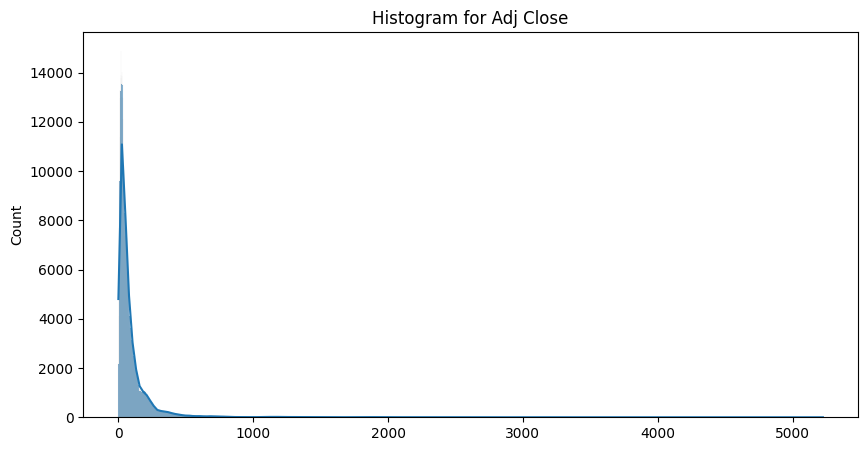

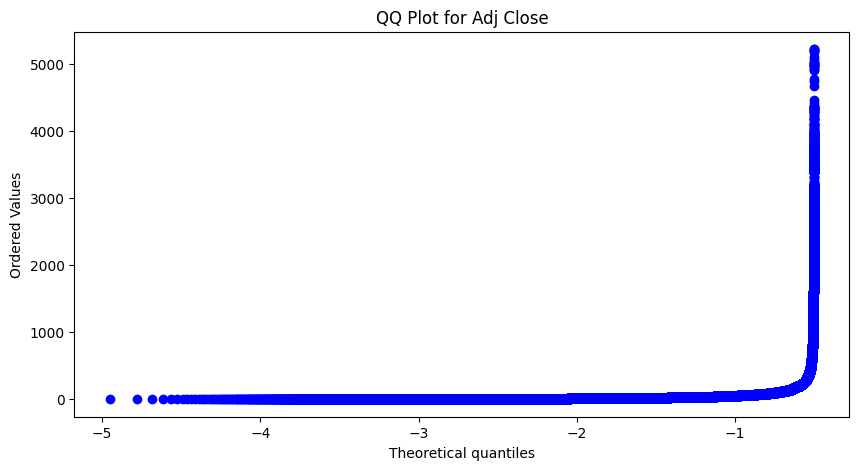

Shapiro-Wilk Test for Adj Close: Stat=nan, p-value=nan
The distribution of Adj Close is not normal.



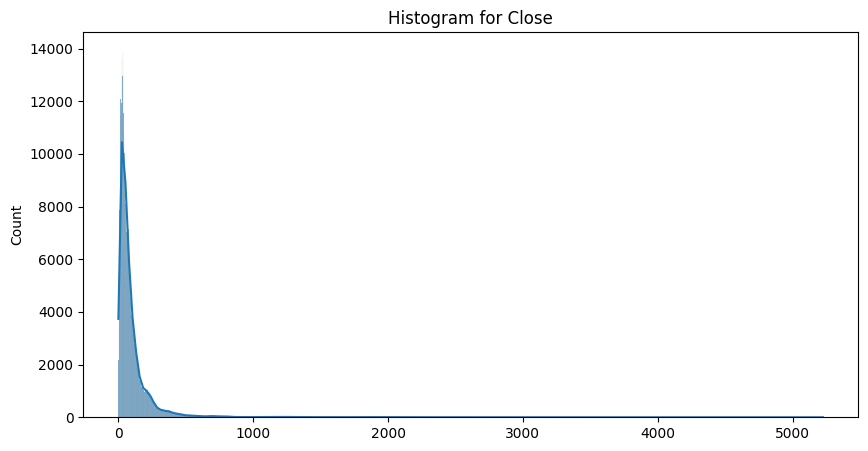

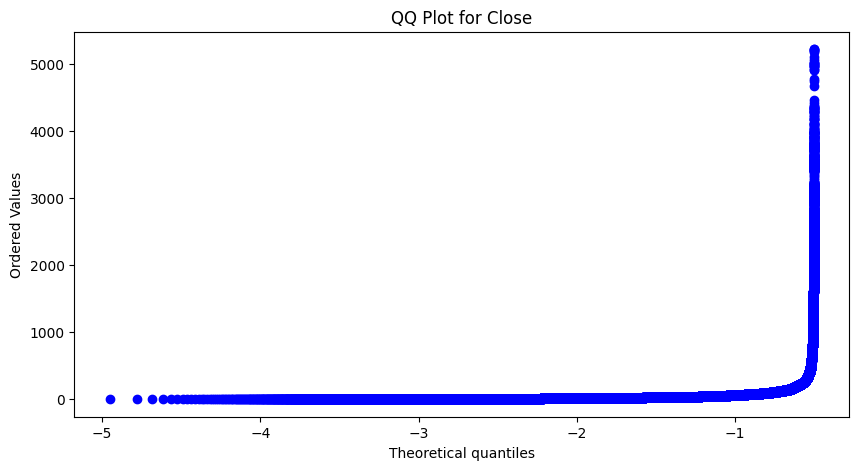

Shapiro-Wilk Test for Close: Stat=nan, p-value=nan
The distribution of Close is not normal.



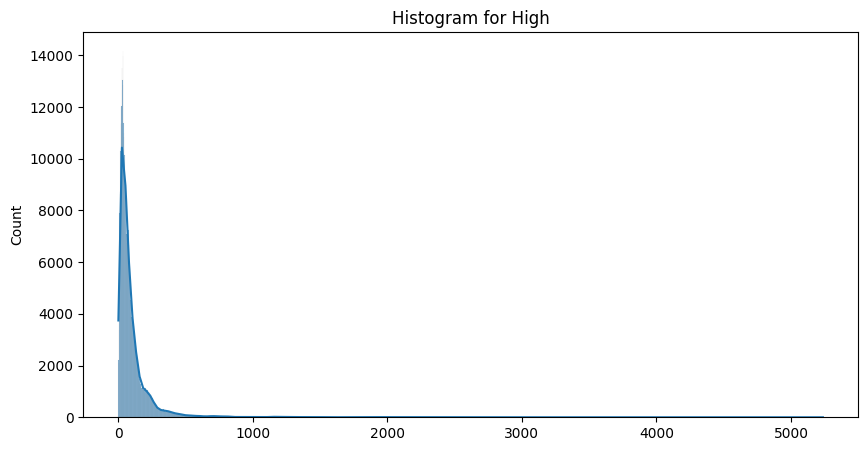

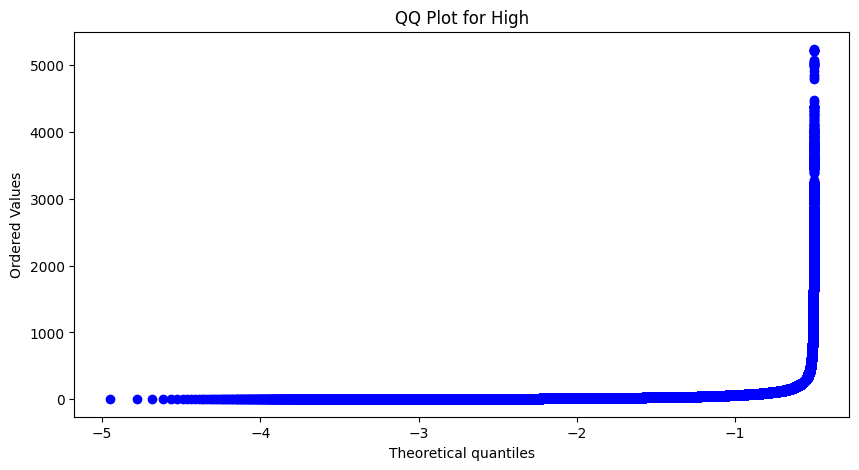

Shapiro-Wilk Test for High: Stat=nan, p-value=nan
The distribution of High is not normal.



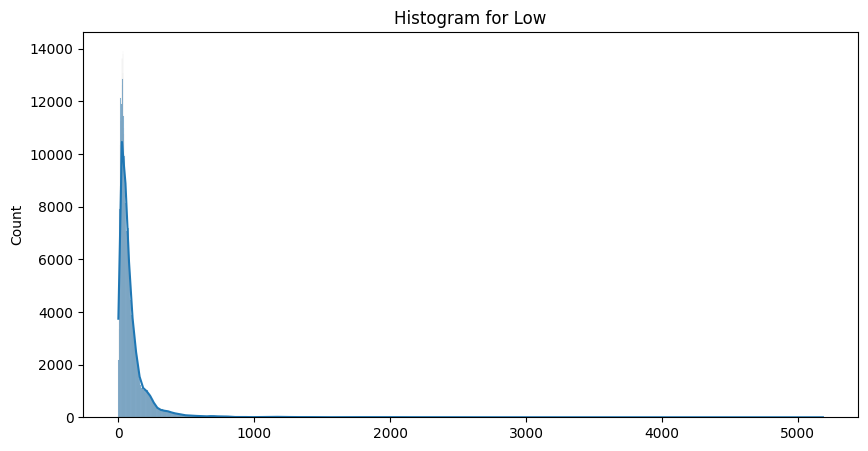

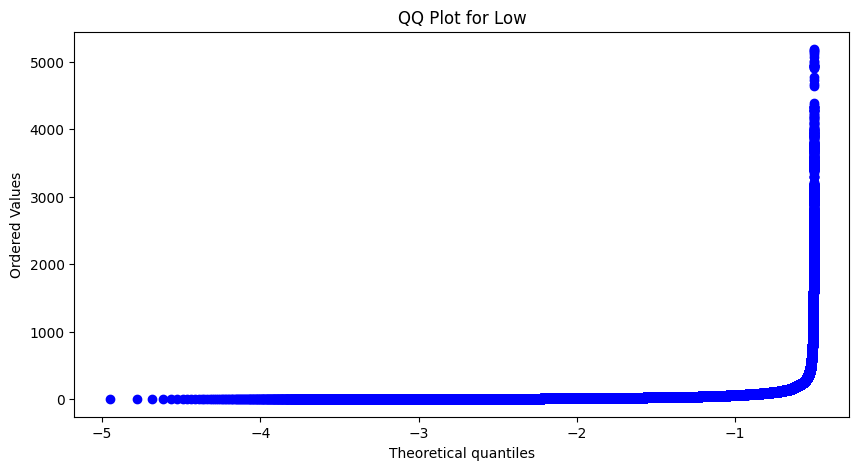

Shapiro-Wilk Test for Low: Stat=nan, p-value=nan
The distribution of Low is not normal.



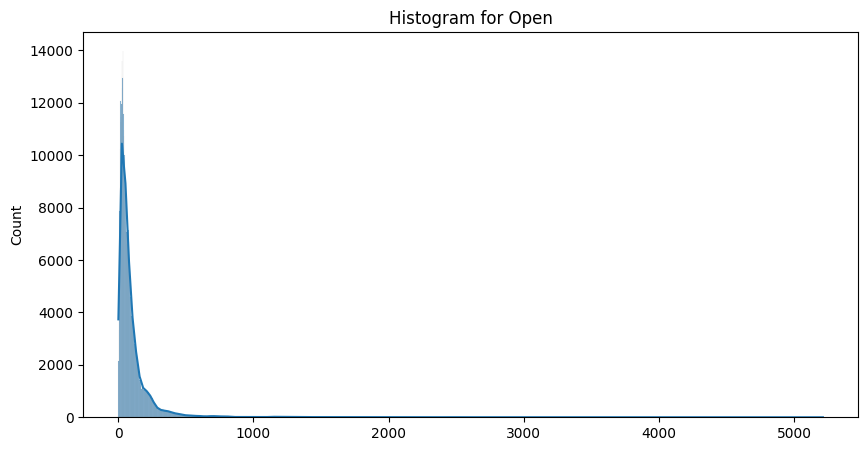

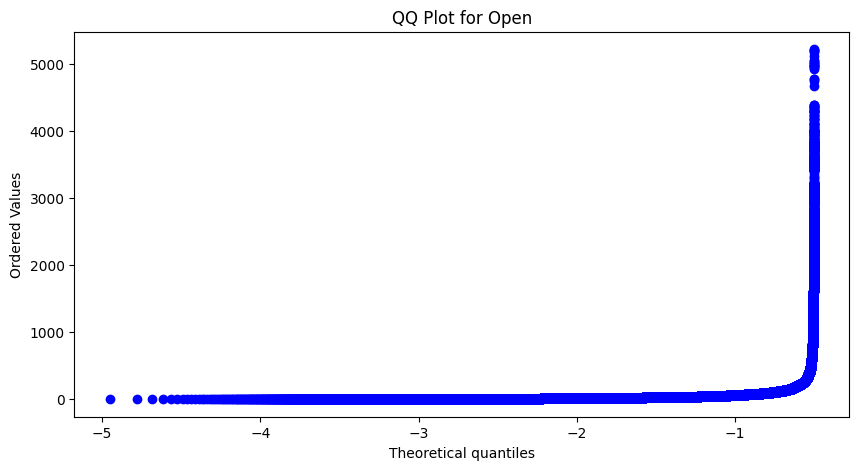

Shapiro-Wilk Test for Open: Stat=nan, p-value=nan
The distribution of Open is not normal.



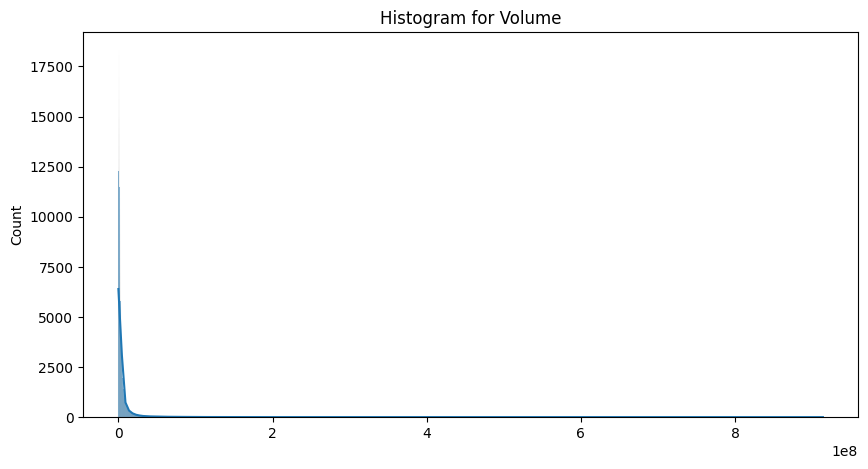

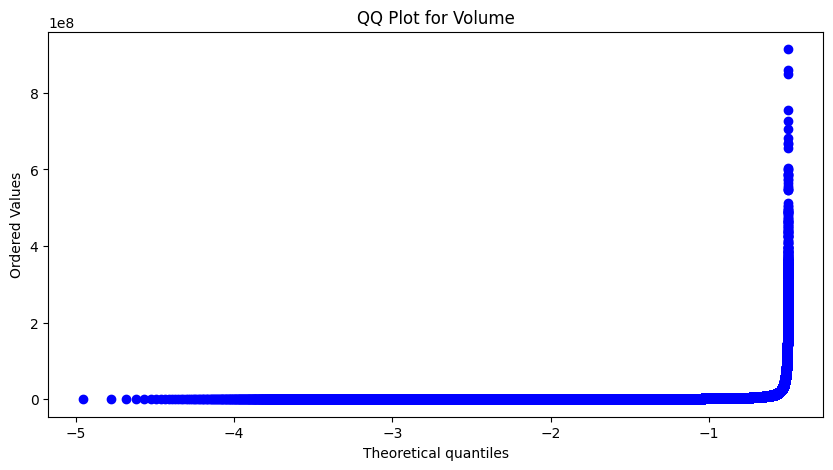

Shapiro-Wilk Test for Volume: Stat=nan, p-value=nan
The distribution of Volume is not normal.



In [7]:
numeric_columns = stocks.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    data = stocks[column].values 
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data, kde=True)
    plt.title(f'Histogram for {column}')
    plt.show()

    plt.figure(figsize=(10, 5))
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'QQ Plot for {column}')
    plt.show()


    stat, p_value = stats.shapiro(data)
    print(f'Shapiro-Wilk Test for {column}: Stat={stat:.3f}, p-value={p_value:.3f}')
    
    if p_value > 0.05:
        print(f'The distribution of {column} is normal.\n')
    else:
        print(f'The distribution of {column} is not normal.\n')

In [8]:
stocks['Close'].describe()

count    581588.000000
mean        110.365154
std         211.727166
min           1.030000
25%          32.029999
50%          59.820000
75%         113.610001
max        5224.279785
Name: Close, dtype: float64

In [9]:
stocks['Volume'].describe()

count    5.815880e+05
mean     6.119957e+06
std      1.777728e+07
min      0.000000e+00
25%      8.722500e+05
50%      1.964600e+06
75%      4.536600e+06
max      9.140820e+08
Name: Volume, dtype: float64

Nižšie môžeme vidieť graf SP500 indexu počas celého obdobia

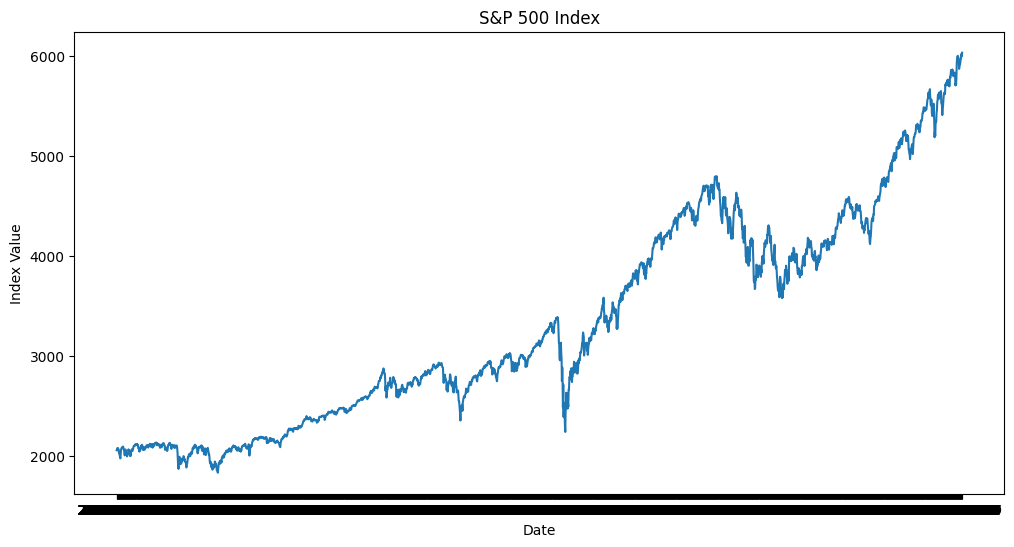

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(index['Date'], index['S&P500'])
plt.title('S&P 500 Index')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.show()

# Duplicate records

There are no duplicate records or duplicate columns in the data. The data has a suitable structure.

In [11]:
index[index.duplicated()]

,Date,S&P500


In [12]:
stocks[stocks.duplicated()]

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume


# Missing values

We deleted records with missing values from the stocks table since these records contained only the date and symbol, providing no value to the model.

In [13]:
index.isna().sum().sum()

np.int64(0)

In [14]:
stocks.isna().sum()

Date               0
Symbol             0
Adj Close    1306674
Close        1306674
High         1306674
Low          1306674
Open         1306674
Volume       1306674
dtype: int64

In [15]:
stocks.dropna(inplace=True)

In [16]:
stocks.shape

(581588, 8)

# Outliers

Based on the boxplot, we can see that outliers are present only in the Volume column of the stocks table, from which we have removed them.

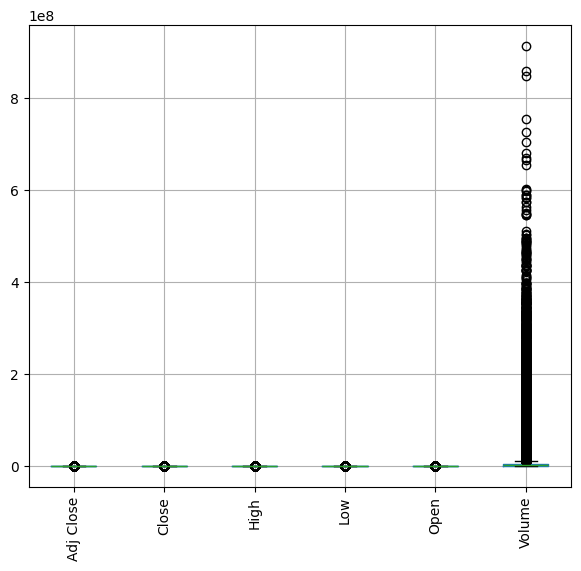

In [17]:
plt.figure(figsize=(7, 6))
stocks.boxplot()
plt.xticks(rotation=90)
plt.show()

In [18]:
def delete_outliers(df, column_name):
    mean = df[column_name].mean()
    std = df[column_name].std()
    new_df = df[(df[column_name] >= mean - 3 * std) & (df[column_name] <= mean + 3 * std)]
    print("deleted", df.shape[0] - new_df.shape[0], "outliers.")
    return new_df

In [19]:
stocks = delete_outliers(stocks, "Volume")

deleted 9636 outliers.


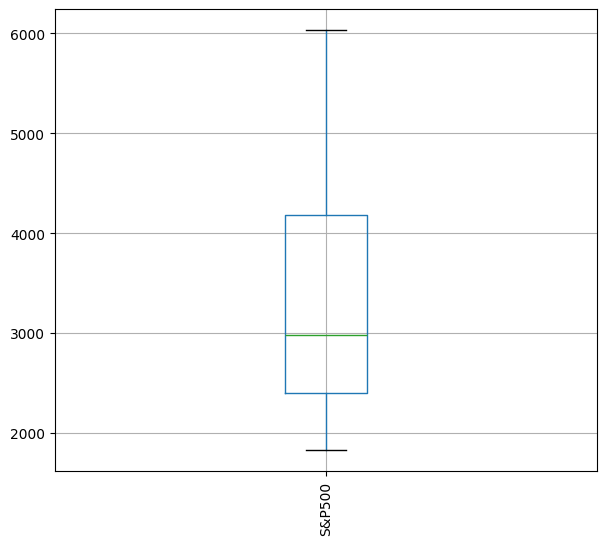

In [20]:
plt.figure(figsize=(7, 6))
index.boxplot()
plt.xticks(rotation=90)
plt.show()

# Pairwise data analysis

To identify relationships and dependencies, we created a correlation map. We identified pairs of variables with significant correlations. From this, we found that the most significant correlation is between the combinations of the variables Adj Close, Close, High, Low, and Open. Such a relationship was expected, as all these values represent similar information. It is sufficient to keep just one of them to reduce the data volume and avoid overfitting.

<Axes: >

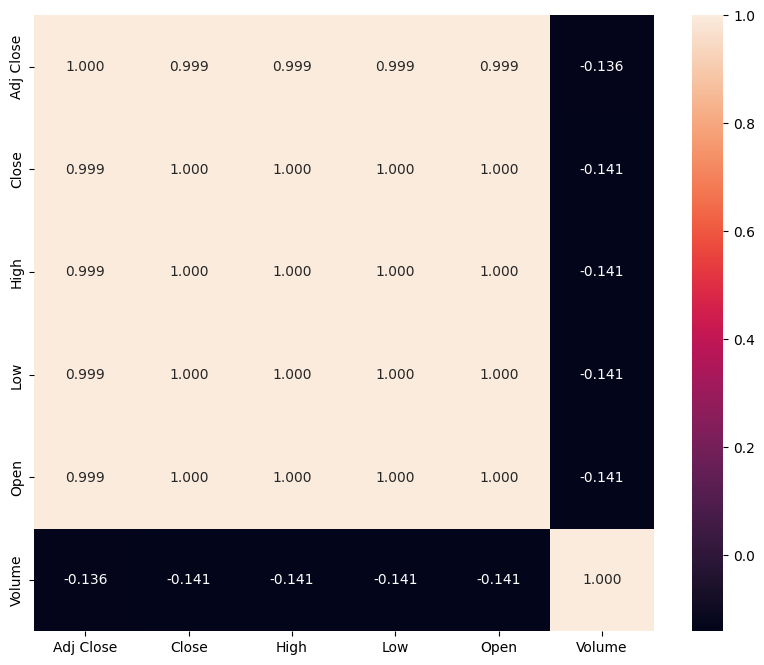

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(stocks.iloc[:, 2:].corr(), ax=ax, annot=True, fmt=".3f")

In [22]:
stocks.drop(columns=["Adj Close", "Open", "High", "Low"], inplace=True)

In [23]:
stocks.head(2)

,Date,Symbol,Close,Volume
22524,2010-01-04,AMD,9.70,18748700.0
22525,2010-01-05,AMD,9.71,22145700.0


In [24]:
merged = pd.merge(stocks, index, on='Date', how='inner')
merged.head(3)

,Date,Symbol,Close,Volume,S&P500
0,2014-12-01,AMD,2.67,16025100.0,2053.44
1,2014-12-02,AMD,2.68,12438800.0,2066.55
2,2014-12-03,AMD,2.74,18256500.0,2074.33


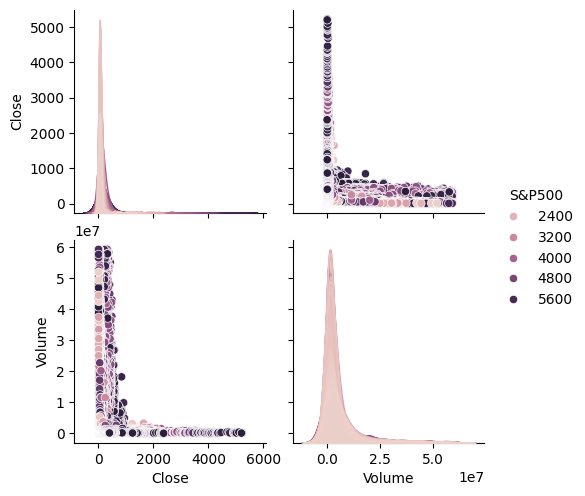

In [25]:
sns.pairplot(data=merged.iloc[:, 2:], hue="S&P500")
plt.show()

# Data transformation

In [26]:
stocks.Date.nunique()

3754

In [27]:
stocks.Date.unique()

array(['2010-01-04', '2010-01-05', '2010-01-06', ..., '2024-10-10',
       '2024-10-29', '2024-10-30'], dtype=object)

In [28]:
stocks[stocks['Date'] == '2010-01-04']

,Date,Symbol,Close,Volume
22524,2010-01-04,AMD,9.700000,18748700.0
37540,2010-01-04,APD,76.928772,1131483.0
45048,2010-01-04,AKAM,25.920000,3015600.0
56310,2010-01-04,ALGN,18.500000,374200.0
63818,2010-01-04,LNT,15.175000,1332800.0
...,...,...,...,...
1820690,2010-01-04,WBD,15.840572,2844108.0
1843214,2010-01-04,WST,19.735001,232800.0
1854476,2010-01-04,WMB,17.616472,7020240.0
1865738,2010-01-04,XEL,21.080000,2670400.0


In [29]:
index.shape[0] == index.Date.nunique()

True

The stocks table contains data for all stocks for each date, with only one value per date in the index. Therefore, we will create aggregated data from the stocks table and merge it with the index table.

In [30]:
daily_metrics = stocks.groupby('Date').agg({
    'Close': 'mean',
    'Volume': 'sum'
}).reset_index()
daily_metrics.columns = ['Date', 'Close_mean', 'Volume_sum']

In [31]:
merged = pd.merge(daily_metrics, index, on='Date', how='inner')
merged = merged.sort_values(by='Date').reset_index(drop=True)

## Test for stationarity of the data

According to the test, we can see that the data is not stationary, so we attempted to transform it.

In [32]:
dftest = adfuller(merged['S&P500'], autolag='AIC')
print("\t1. ADF : ",dftest[0])
print("\t2. P-Value : ", dftest[1])
print("\t3. Num Of Lags : ", dftest[2])

if dftest[1] <= 0.05:
    print("Časový rad je stacionárny.")
else:
    print("Časový rad nie je stacionárny.")

	1. ADF :  0.7431774866586325
	2. P-Value :  0.9906613106672583
	3. Num Of Lags :  10
Časový rad nie je stacionárny.


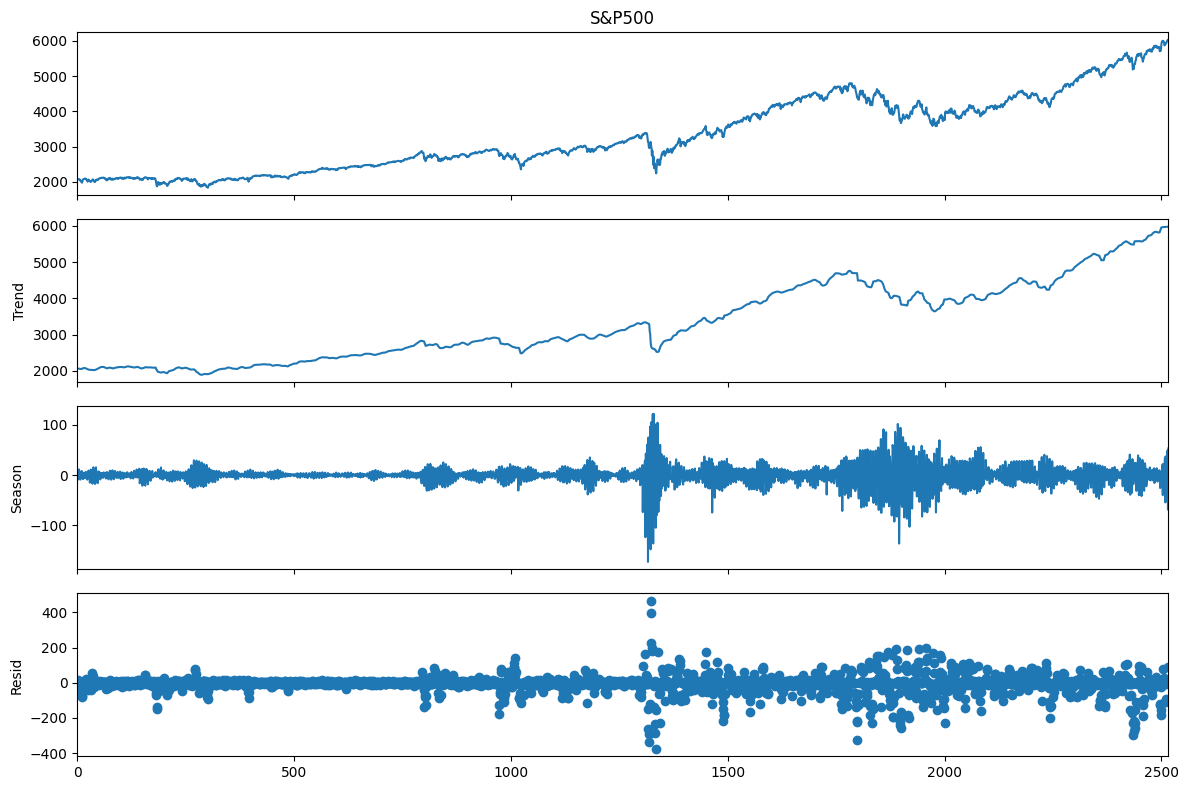

In [33]:
result = STL(merged['S&P500'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result.plot()
plt.show()
data = result.trend

We transformed the data by differencing.

In [34]:
merged['S&P500_diff'] = merged['S&P500'].diff()
merged.dropna(inplace=True)
merged
dftest = adfuller(merged['S&P500_diff'], autolag='AIC')
print("\t1. ADF : ",dftest[0])
print("\t2. P-Value : ", dftest[1])
print("\t3. Num Of Lags : ", dftest[2])

if dftest[1] <= 0.05:
    print("Časový rad je stacionárny.")
else:
    print("Časový rad nie je stacionárny.")

	1. ADF :  -15.995296252928318
	2. P-Value :  6.60218568778858e-29
	3. Num Of Lags :  9
Časový rad je stacionárny.


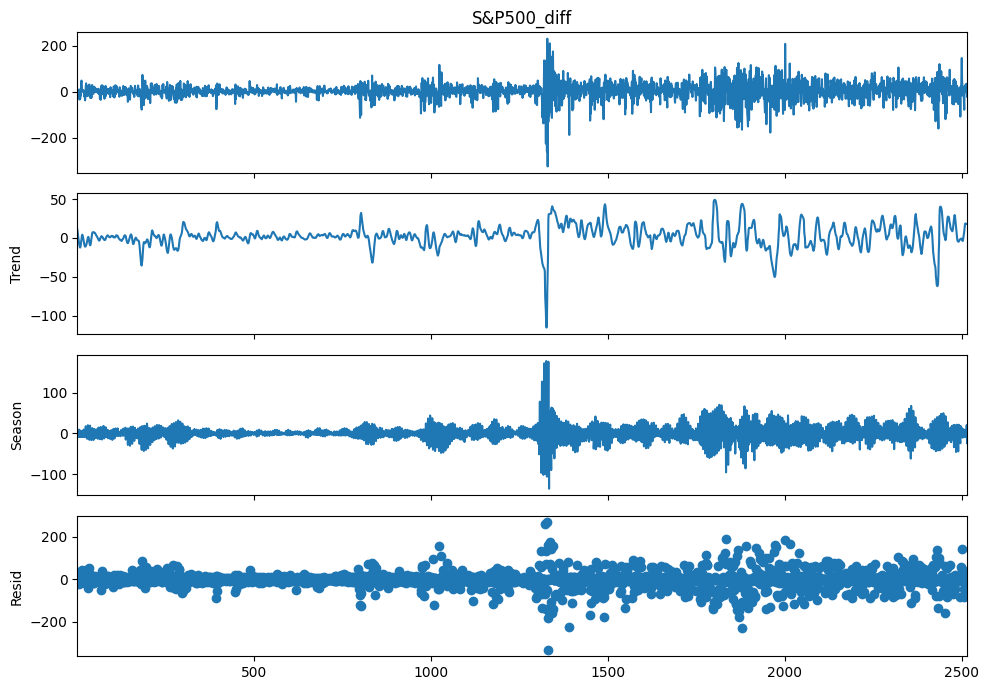

In [35]:
result = STL(merged['S&P500_diff'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (10,7)
result.plot()
plt.show()
data_cleaned = result.trend.to_numpy().reshape(-1,1)

# Selection of ML/DL methods

Our dataset represents individual stocks that are part of the S&P 500 index and the value of this index over the period from 2004 to 2024. These are time series data, which have important characteristics such as trends and seasonality, which need to be considered when modeling. Therefore, techniques specifically designed for time series are the most suitable.

We chose LSTM (Long Short-Term Memory) because it is effective for working with time series. It can capture dependencies between values in time series, which is crucial for predicting the S&P 500 index value, as past values are important for predicting future values. Since stock prices are often unpredictable, using simpler models like ARIMA is not sufficient.

We utilized the TimeseriesGenerator because it provides flexibility when working with data. It allows us to directly set the look_back, which enables us to split the data into sequences.

In [36]:
def get_y_from_generator(gen):
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

# The model using the close and volume attributes 

## Data splitting 

We split the data into a train and test set in an 80:20 ratio.

In [37]:
train_size = int(len(merged) * 0.80)
test_size = len(merged) - train_size
train, test = merged.iloc[:train_size], merged.iloc[train_size:]
print("train shape: ", train.shape)
print("test shape: ", test.shape)

train shape:  (2012, 5)
test shape:  (504, 5)


## Data normalization

We normalized the close_mean and volume_sum attributes using MinMaxScaler and the SP500 index using StandardScaler, which we fitted on the train data and applied to the test data as well. We created a separate scaler for the SP500 values because we will also scale them back later. Additionally, we created instances of test_data_gen and train_data_gen.

In [38]:
scaler = MinMaxScaler()
scaler_sp500 = StandardScaler()

train[['Close_mean', 'Volume_sum']] = scaler.fit_transform(train[['Close_mean', 'Volume_sum']])
train['S&P500'] = scaler_sp500.fit_transform(train[['S&P500']])
train_trans = train[['Close_mean', 'Volume_sum', 'S&P500']]
train_trans = train_trans.to_numpy()

test[['Close_mean', 'Volume_sum']] = scaler.transform(test[['Close_mean', 'Volume_sum']])
test['S&P500'] = scaler_sp500.transform(test[['S&P500']])
test_trans = test[['Close_mean', 'Volume_sum', 'S&P500']]
test_trans = test_trans.to_numpy()

## Model

We tried different combinations in the model, changing the number of units and activation functions in LSTM, activation in Dense, learning rate, and the number of epochs. Our best model uses non-stationary data, 3 attributes, with the LSTM having 30 units, the Dense layer having 1 unit and a linear kernel. We use a learning rate of 0.001 and 20 epochs for training.

In [39]:
look_back = 30 
train_data_gen = TimeseriesGenerator(train_trans, 
                                train_trans[:, 2], 
                                length=look_back, 
                                batch_size=5
                               )
test_data_gen = TimeseriesGenerator(test_trans, 
                               test_trans[:, 2], 
                               length=look_back, 
                               batch_size=5
                                )

In [40]:
n_features = 3
x = Input(shape=(look_back, n_features)) 
h = LSTM(units=30)(x) 
y = Dense(units=1, activation='linear')(h) 
model = Model(inputs=x, outputs=y)
print(model.summary())

opt = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30)             │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,111 (16.06 KB)

 Trainable params: 4,111 (16.06 KB)

 Non-trainable params: 0 (0.00 B)

None


In [41]:
model.fit(train_data_gen, epochs=20, shuffle=True)

Epoch 1/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1660 - mae: 0.2413 - mse: 0.1660    
Epoch 2/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077 - mae: 0.0607 - mse: 0.0077
Epoch 3/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072 - mae: 0.0586 - mse: 0.0072
Epoch 4/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067 - mae: 0.0578 - mse: 0.0067
Epoch 5/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0063 - mae: 0.0559 - mse: 0.0063
Epoch 6/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - mae: 0.0446 - mse: 0.0041        
Epoch 7/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039 - mae: 0.0431 - mse: 0.0039        
Epoch 8/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0046 - mae: 0.0472 - mse: 0.0046
Epoch 9/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039 - mae: 0.0414 - mse: 0.0039
Epoch 10/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0047 - mae: 0.0473 - mse: 0.0047
Epoch 11/20
397/397 ━━━━━━━━━

MAE a MSE majú nízku hodnotu, čo znamená, že model robí dobré predikcie a odchýlka medzi predikovanými a skutočnými dátami je malá.

In [42]:
model.evaluate(test_data_gen)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 0.0036 - mae: 0.0461 - mse: 0.0036


[0.010856456123292446, 0.010856456123292446, 0.07664301246404648]

In [43]:
trainPredict = model.predict(train_data_gen)
print(trainPredict.shape)
testPredict = model.predict(test_data_gen)
print(testPredict.shape)
trainPredict = scaler_sp500.inverse_transform(trainPredict)
testPredict = scaler_sp500.inverse_transform(testPredict)

397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
(1982, 1)
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
(474, 1)


In [44]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)
trainY = scaler_sp500.inverse_transform(trainY)
testY = scaler_sp500.inverse_transform(testY)

(1982, 1)
(474, 1)


In [45]:
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 46.58 RMSE
Test Score: 84.55 RMSE


Based on the RMSE, we can see that the model has slight **overfitting**. The graph shows that the model closely follows the data, but there is still room for improvement.

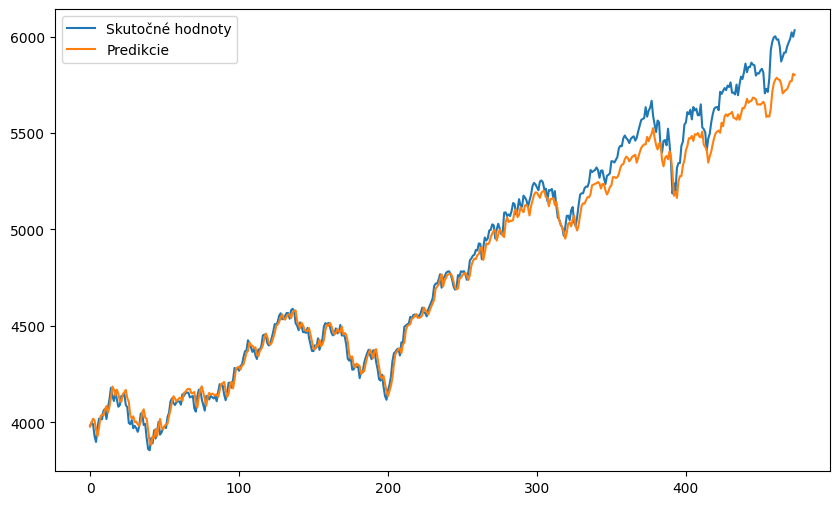

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Skutočné hodnoty')
plt.plot(testPredict, label='Predikcie')
plt.legend()
plt.show()

We tried many versions of the model using the close and volume attributes, experimenting with both stationary and original data, and modifying hyperparameters. However, none of the models performed well, and each one **suffered from overfitting**. This overfitting might be caused by using unnecessary attributes that introduce noise. Therefore, we decided to try predicting the value of the S&P 500 index based solely on historical data.

# Model using only historical data 

## Data Splitting and Normalization

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_trans = scaler.fit_transform(data_cleaned)

train_size = int(len(data_trans) * 0.80)
test_size = len(data_trans) - train_size
train, test = data_trans[0:train_size,:], data_trans[train_size:len(data_trans),:]

## Model

In [48]:
look_back = 10
train_data_gen = TimeseriesGenerator(train, 
                                     train,
                                     length=look_back, 
                                     sampling_rate=1,
                                     stride=1,
                                     batch_size=1
                                    )
test_data_gen = TimeseriesGenerator(test, 
                                    test,
                                    length=look_back, 
                                    sampling_rate=1,
                                    stride=1,
                                    batch_size=1
                                   )

The best model we found is an RNN with an LSTM layer that has 5 units, a Dense layer with a linear kernel, and a learning rate of 0.001.

In [49]:
x = Input(shape=(look_back, 1))
h = LSTM(units=5)(x)   
y = Dense(units=1, activation='linear')(h)
model = Model(inputs=x, outputs=y)
print(model.summary())

opt = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5)              │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146 (584.00 B)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [50]:
model.fit(train_data_gen, epochs=20, shuffle=True)

Epoch 1/20
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0693 - mae: 0.1375 - mse: 0.0693
Epoch 2/20
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0027 - mae: 0.0339 - mse: 0.0027   
Epoch 3/20
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0021 - mae: 0.0297 - mse: 0.0021
Epoch 4/20
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0012 - mae: 0.0227 - mse: 0.0012
Epoch 5/20
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.4371e-04 - mae: 0.0184 - mse: 8.4371e-04
Epoch 6/20
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 2s 998us/step - loss: 5.9816e-04 - mae: 0.0154 - mse: 5.9816e-04 
Epoch 7/20
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.1316e-04 - mae: 0.0130 - mse: 5.1316e-04
Epoch 8/20
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.8350e-04 - mae: 0.0122 - mse: 4.8350e-04
Epoch 9/20
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.7374e-04 - mae: 0.0105 - mse: 2.7374e-04
Epoch 10/20
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.9507e-04 - mae: 

In [51]:
model.evaluate(test_data_gen)

494/494 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 1.4605e-04 - mae: 0.0074 - mse: 1.4605e-04


[0.000172006111824885, 0.000172006111824885, 0.007920242846012115]

In [52]:
trainPredict = model.predict(train_data_gen)
print(trainPredict.shape)
testPredict = model.predict(test_data_gen)
print(testPredict.shape)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

2002/2002 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step 
(2002, 1)
494/494 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
(494, 1)
(2002, 1)
(494, 1)


In [53]:
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.90 RMSE
Test Score: 2.15 RMSE


The RMSE values are relatively low and very similar, which allows us to conclude that **the model is performing well and does not exhibit overfitting.**

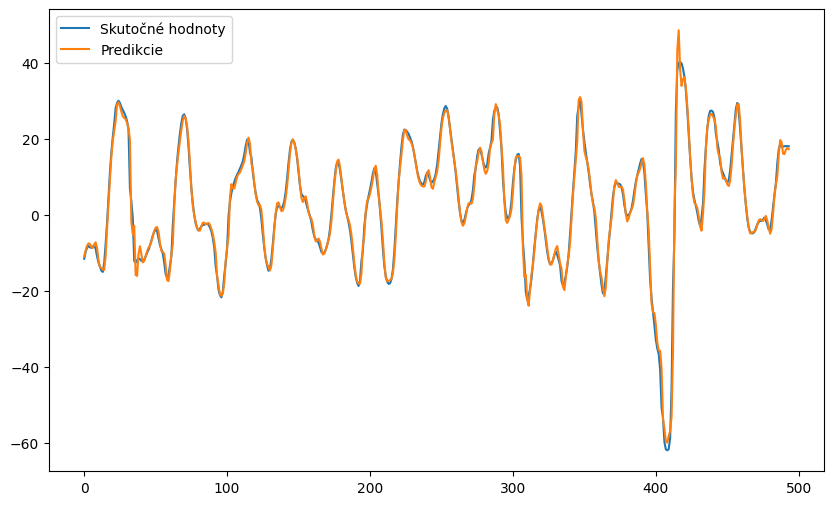

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Skutočné hodnoty')
plt.plot(testPredict, label='Predikcie')
plt.legend()
plt.show()

# Evaluation of the Approach and Results

We used an LSTM (Long Short-Term Memory) neural network to predict the value of the S&P 500 index, using the historical data of the S&P 500 index along with aggregated close and volume data from stocks as inputs to the model. This helps identify potential relationships between the predicted variable and other variables. We found that the aggregated data did not improve the model; on the contrary, it added noise that harmed the model's performance. Therefore, we predicted the index solely based on historical data.

The model achieved the following metrics on the test set:

Train Score: 2.75 RMSE
Test Score: 2.97 RMSE
The graph shows that the model closely follows the trend of the actual values, indicating its ability to generalize to new data. The train and test scores are very similar, which suggests that the model is neither overfitting nor underfitting. The model's predictions are good, and it is stable, as it consistently produces similar results when run multiple times.